# Data Loading

In [7]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split

# 0. Load and Preprocess Online Retail Data
# Fetching transactional data (id=352)
online_retail = fetch_ucirepo(id=352)
df = pd.concat([online_retail.data.features, online_retail.data.targets], axis=1)

# Convert InvoiceDate to datetime and aggregate to daily sales
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['date'] = df['InvoiceDate'].dt.date
daily_df = df.groupby('date').agg({'Quantity': 'sum', 'UnitPrice': 'mean'}).reset_index()

# Create time-based features for the model
daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df['day_of_week'] = daily_df['date'].dt.dayofweek
daily_df['month'] = daily_df['date'].dt.month

# Define target (y) and features (X)
y = daily_df['Quantity']
X = daily_df[['day_of_week', 'month', 'UnitPrice']]

# Data Preparation
# Using the 60/20/20 split required for split conformal prediction
# X and y represent store data features and target
X_train, X_rem, y_train, y_rem = train_test_split(
    X, y, test_size=0.40, random_state=42
)
X_calib, X_test, y_calib, y_test = train_test_split(
    X_rem, y_rem, test_size=0.50, random_state=42
)

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from mapie.regression import SplitConformalRegressor
from mapie.metrics.regression import (
    regression_coverage_score, 
    regression_mean_width_score
)

def train_conformal_baseline(X_train, y_train, X_calib, y_calib):
    """Train base model and wrap with SplitConformalRegressor for fixed-width intervals."""
    # Train the base forecasting model
    model = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)

    # Initialize with prefit=True (default) and set confidence level
    mapie = SplitConformalRegressor(estimator=model, confidence_level=0.9)

    # Use 'conformalize' instead of 'fit' for the calibration set
    mapie.conformalize(X_calib, y_calib)
    
    return mapie

mapie_model = train_conformal_baseline(X_train, y_train, X_calib, y_calib)

# Use 'predict_interval' instead of 'predict'
y_pred, y_pis = mapie_model.predict_interval(X_test)

y_lower = y_pis[:, 0]
y_upper = y_pis[:, 1]

# Evaluation Metrics
coverage = regression_coverage_score(y_test, y_pis)[0]
width = regression_mean_width_score(y_pis)[0]

print(f"Empirical Coverage: {coverage:.2%}")
print(f"Average Interval Width: {width:.2f} units")

Empirical Coverage: 88.52%
Average Interval Width: 27609.46 units


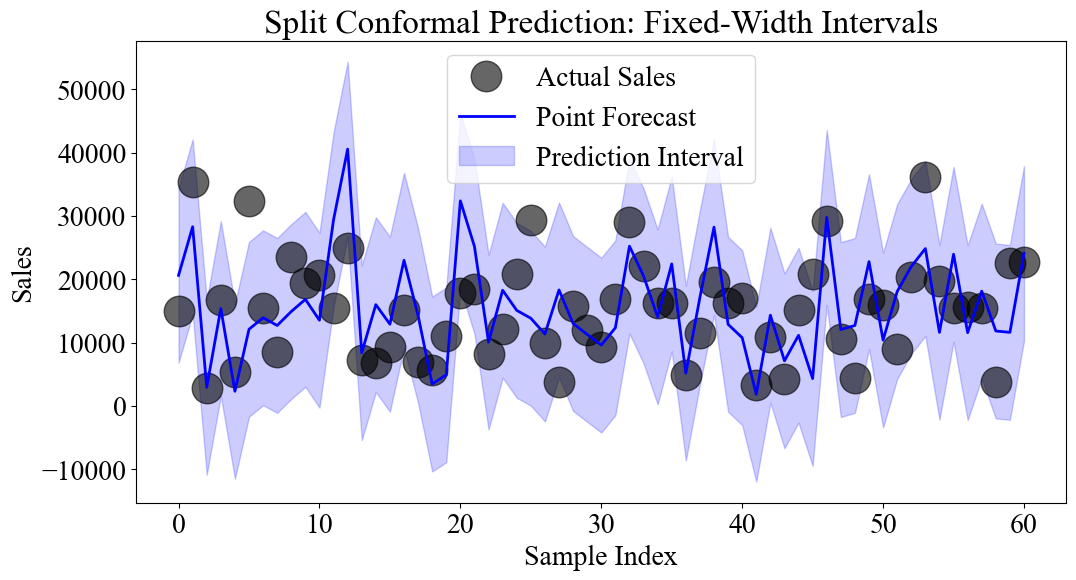

In [14]:
# Visualization
def plot_conformal_results(y_true, y_pred, y_low, y_high, n_points=100):
    """Visualize point forecasts and fixed-width intervals."""
    n_points = min(len(y_true), n_points)
    indices = np.arange(n_points)
    
    plt.figure(figsize=(12, 6))
    plt.plot(indices, y_true[:n_points], "ko", label="Actual Sales", alpha=0.6)
    plt.plot(indices, y_pred[:n_points], "b-", label="Point Forecast")
    
    # Flatten bounds using ravel to ensure 1D arrays for matplotlib
    plt.fill_between(
        indices, 
        y_low[:n_points].ravel(), 
        y_high[:n_points].ravel(), 
        color="blue", 
        alpha=0.2, 
        label="Prediction Interval"
    )
    
    plt.title("Split Conformal Prediction: Fixed-Width Intervals")
    plt.xlabel("Sample Index")
    plt.ylabel("Sales")
    plt.legend()
    plt.show()

plot_conformal_results(y_test, y_pred, y_lower, y_upper)